<a href="https://colab.research.google.com/github/rpimaster/OAI/blob/main/02-autoencoder/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


torch.Size([1, 28, 28]) 1.0 0.0 torch.float32


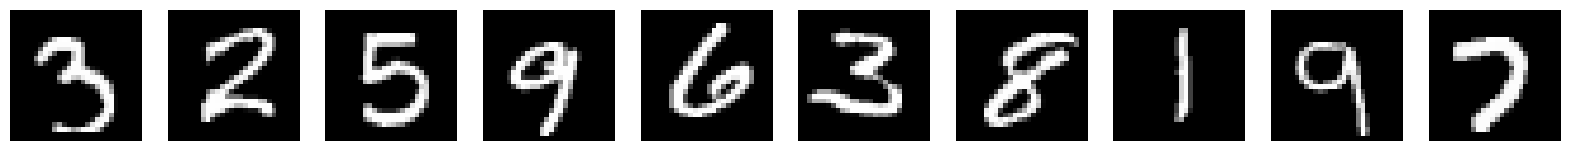

In [3]:
# dataloader for training
batch_size = 128
train_loader = DataLoader(datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
train_iter = iter(train_loader)
# get first batch - images and labels
x_sample, _ = next(train_iter)
# float images 28 x 28, 0.0-1.0
print(x_sample[0].shape,torch.max(x_sample[0]).item(),torch.min(x_sample[0]).item(),x_sample[0].dtype)
# save first samples
os.makedirs('mnist', exist_ok=True)
for i in range(10):
    cv2.imwrite('mnist/inp'+str(i).zfill(5)+".png",np.asarray(x_sample[i].squeeze(0).detach().numpy()*255,np.uint8))
# show first samples
plt.figure(figsize=(20, 2))
for i in range(10):
    img = (x_sample[i].squeeze(0).detach().numpy()*255).astype(np.uint8)
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# dataloader for testing
test_loader = DataLoader(datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=False)

In [5]:
# architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution layers and max pooling of encoder
        self.encoder = nn.Sequential(
            # --- Block 1 ---
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # [B, 1, 28, 28] -> [B, 16, 28, 28]  # 16 x (1 x 9 + 1)
            nn.ReLU(),                                                                         # 0
            nn.Conv2d(16, 16, kernel_size=3, padding=1),  # [B, 16, 28, 28] -> [B, 16, 28, 28] # 16 x (16 x 9 + 1)
            nn.ReLU(),                                                                         # 0
            nn.MaxPool2d(2),                              # [B, 16, 28, 28] -> [B, 16, 14, 14] # 0
            # --- Block 2 ---
            nn.Conv2d(16, 8, kernel_size=3, padding=1),   # [B, 16, 14, 14] -> [B, 8, 14, 14]  # 8 x (16 x 9 + 1)
            nn.ReLU(),                                                                         # 0
            nn.Conv2d(8, 8, kernel_size=3, padding=1),    # [B, 8, 14, 14] -> [B, 8, 14, 14]   # 8 x (8 x 9 + 1)
            nn.ReLU(),                                                                         # 0
            nn.MaxPool2d(2),                              # [B, 8, 14, 14] -> [B, 8, 7, 7]     # 0
            # --- Block 3 ---
            nn.Conv2d(8, 8, kernel_size=3),               # [B, 8, 7, 7] -> [B, 8, 5, 5]       # 8 x (8 x 9 + 1)
            nn.ReLU(),                                                                         # 0
            nn.Conv2d(8, 8, kernel_size=3),               # [B, 8, 5, 5] -> [B, 8, 3, 3]       # 8 x (8 x 9 + 1)
            nn.Sigmoid(),                                  # output 0-1                        # 0
            nn.Flatten()                                  # [B, 8, 3, 3] -> [B, 72]            # 0
        )
        # convolution layers and upsampling of decoder
        self.decoder = nn.Sequential(
            # --- Block 3 reversed ---
            nn.Unflatten(1, (8, 3, 3)),                   # [B, 72] -> [B, 8, 3, 3]
            nn.ConvTranspose2d(8, 8, kernel_size=3),      # [B, 8, 3, 3] -> [B, 8, 5, 5]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=3),      # [B, 8, 5, 5] -> [B, 8, 7, 7]
            nn.ReLU(),
            # --- Block 2 reversed ---
            nn.Upsample(scale_factor=2, mode='nearest'),  # [B, 8, 7, 7] -> [B, 8, 14, 14]
            nn.Conv2d(8, 8, kernel_size=3, padding=1),    # [B, 8, 14, 14] -> [B, 8, 14, 14]
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),   # [B, 8, 14, 14] -> [B, 16, 14, 14]
            nn.ReLU(),
            # --- Block 1 reversed ---
            nn.Upsample(scale_factor=2, mode='nearest'),  # [B, 16, 14, 14] -> [B, 16, 28, 28]
            nn.Conv2d(16, 16, kernel_size=3, padding=1),  # [B, 16, 28, 28] -> [B, 16, 28, 28]
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),   # [B, 16, 28, 28] -> [B, 1, 28, 28]
            nn.Sigmoid()                                  # output 0–1
        )
    def forward(self, x):
        # apply encoder
        features = self.encoder(x)
        # apply decoder
        return self.decoder(features)
    def __str__(self):
        return str(self.encoder)+str(self.decoder)

In [6]:
autoencoder = Autoencoder().to(device)
print(autoencoder)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (13): Sigmoid()
  (14): Flatten(start_dim=1, end_dim=-1)
)Sequential(
  (0): Unflatten(dim=1, unflattened_size=(8, 3, 3))
  (1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): Upsample(scale_factor=2.0, mode='nearest')
  (6): Conv2d(8, 8, ker

In [7]:
# Define optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [9]:
# Training
autoencoder.train() # change model in the training mode
epochs_count = 300 # min. 80
for epoch in range(epochs_count):

    # to record loss and accuracy
    batch_loss = np.array([])
    batch_acc = np.array([])

    for batch, (x_train, _) in enumerate(train_loader):

        # send data to device
        input = x_train.to(device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = autoencoder(input)

        # cross entropy loss
        loss = F.binary_cross_entropy(output, input)

        # find gradients
        loss.backward()

        # update parameters using gradients
        optimizer.step()

        # recording loss
        batch_loss = np.append(batch_loss, [loss.item()])

        # recording accuracy
        total_train = input.numel()
        correct_train = (torch.abs(input-output) < 0.1).sum().item()
        acc = (100.0 * correct_train) / total_train
        batch_acc = np.append(batch_acc, [acc])

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()

    print(f'Epoch: {epoch} Loss: {epoch_loss:.6f} Acc: {epoch_acc:.4f}')

KeyboardInterrupt: 

In [10]:
# instead of trainig, we can download its result
!wget http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
autoencoder.load_state_dict(torch.load("pytorch_mnist_autoencoder_model.pth", map_location=torch.device(device)))

--2025-11-05 15:24:33--  http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving agentspace.org (agentspace.org)... 62.168.101.9
Connecting to agentspace.org (agentspace.org)|62.168.101.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth [following]
--2025-11-05 15:24:34--  https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving www.agentspace.org (www.agentspace.org)... 62.168.101.9
Connecting to www.agentspace.org (www.agentspace.org)|62.168.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52651 (51K)
Saving to: ‘pytorch_mnist_autoencoder_model.pth’

pytorch_mnist_autoe 100%[===================>]  51.42K   150KB/s    in 0.3s    

2025-11-05 15:24:36 (150 KB/s) - ‘pytorch_mnist_autoencoder_model.pth’ saved [52651/52651]



<All keys matched successfully>

In [11]:
# validation (evaluation)
autoencoder.eval() # change model in the inference mode
total_test = 0
correct_test = 0

In [12]:
for batch, (x_test, _) in enumerate(test_loader):

    # send data to device
    input = x_test.to(device)
    input.to(device)

    # forward pass to the model
    output = autoencoder(input)

    total_test += input.numel()
    correct_test += (torch.abs(input-output) < 0.1).sum().item()

In [13]:
test_acc = (100.0 * correct_test) / total_test
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 94.7917


In [14]:
# save model weights
model_name = 'pytorch_mnist_autoencoder_model.pth'
torch.save(autoencoder.state_dict(), model_name) # weights only
print(f'Saved trained model at {model_name}')

Saved trained model at pytorch_mnist_autoencoder_model.pth


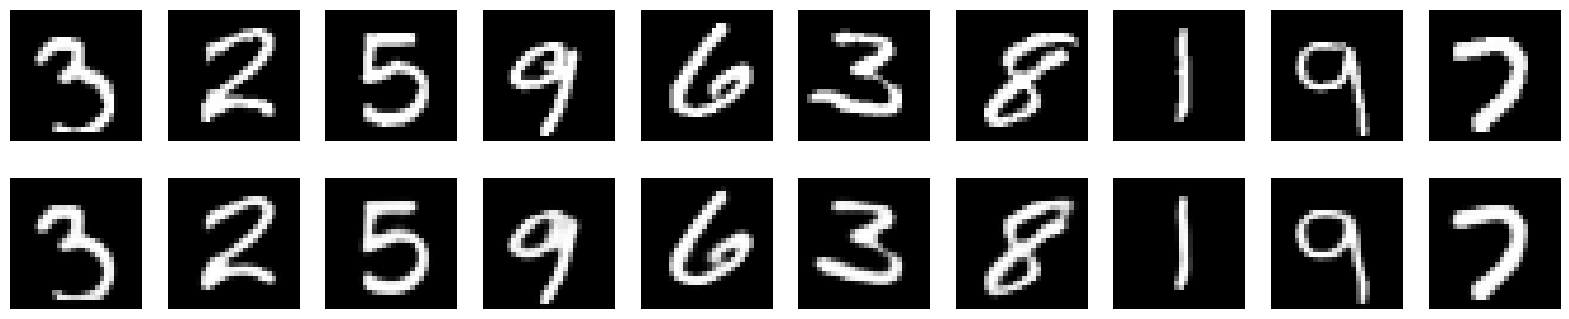

In [15]:
# use the model on few samples
input_images = x_sample[0:10].to(device)
output_images = autoencoder(input_images).to('cpu')
# save first results
for i in range(10):
    cv2.imwrite('mnist/out'+str(i).zfill(5)+".png",np.asarray(output_images[i].squeeze(0).detach().numpy()*255,np.uint8))
# show first results
plt.figure(figsize=(20, 4))
for i in range(10):
    input_img = (x_sample[i].squeeze(0).detach().cpu().numpy()*255).astype(np.uint8)
    plt.subplot(2, 10, i+1)
    plt.imshow(input_img, cmap='gray')
    plt.axis('off')
    output_img = (output_images[i].squeeze(0).detach().cpu().numpy()*255).astype(np.uint8)
    plt.subplot(2, 10, i+1+10)
    plt.imshow(output_img, cmap='gray')
    plt.axis('off')
plt.show()

In [16]:
from google.colab import files
import shutil
files.download(model_name)
shutil.make_archive('mnist_results', 'zip', './mnist')
files.download('mnist_results.zip')
files.download('./mnist/inp00009.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>